# Molecular Dynamics

The following tutorial runs two molecular dynamics (MD) simulations with BigDFT and analyses its outputs. We investigated the dynamics of a water environment with NVE ensamble at DFT level and the motion of a 38 atoms Lennard-Jones cluster with fixed NVT.

In [1]:
from BigDFT import Logfiles as lf
from BigDFT import Calculators as calc
from BigDFT import Inputfiles as I
import matplotlib.pyplot as plt 

## A water environment

To study and reproduce bulk water, we simulate the motion of four water molecules placed in a periodic cubic cell. The cubic unit cell side has been chosen to adjust the effective
density of water to its ambient density.

In [2]:
n = 4 # number of water molecules
m = 18.01528 # [g/mol] molar mass
NA = 6.02214076e23 # [1/mol] Avogadro number
rho = 997e-27 # [g/AA^3] water density at room temperature

volume = ( n * m / NA ) / rho
box_size = volume ** (1.0/3.0)
print('Box size: {} [AA]'.format(box_size))

Box size: 4.932703172202558 [AA]


In [3]:
from io import StringIO
input_file = StringIO("""HETATM    1  H   HOH     0       2.924   3.219   1.550  1.00  0.00           H  
HETATM    2  H   HOH     0       4.098   2.445   0.948  1.00  0.00           H  
HETATM    3  O   HOH     0       3.850   2.984   1.714  1.00  0.00           O  
HETATM    4  H   HOH     1       1.432   4.761   0.988  1.00  0.00           H  
HETATM    5  H   HOH     1       0.066   4.168   0.637  1.00  0.00           H  
HETATM    6  O   HOH     1       0.884   3.972   1.119  1.00  0.00           O  
HETATM    7  H   HOH     2       2.280   0.928   1.171  1.00  0.00           H  
HETATM    8  H   HOH     2       0.907   1.567   1.386  1.00  0.00           H  
HETATM    9  O   HOH     2       1.335   0.779   1.019  1.00  0.00           O  
HETATM   10  H   HOH     3       4.694   4.067   3.659  1.00  0.00           H  
HETATM   11  H   HOH     3       3.377   4.728   4.071  1.00  0.00           H  
HETATM   12  O   HOH     3       3.945   4.569   3.303  1.00  0.00           O  """)

In [4]:
from BigDFT.Atoms import AU_to_A
from BigDFT.IO import read_pdb
from BigDFT.UnitCells import UnitCell

sys = read_pdb(input_file)
sys.cell = UnitCell([box_size, box_size, box_size], units="angstroem")

In [5]:
from BigDFT.Visualization import InlineVisualizer
viz = InlineVisualizer(400,300)
viz.display_system(sys)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Geometry optimization

To avoid large forces (and associated large spatial displacements) at the first MD step,
we relaxed the initial geometry of the atomistic system.

Soft norm-conserving pseudo-potentials including
non-linear core corrections along with the Perdew-Burke-Ernzerhof
functional were used to describe the core electrons and exchange-correlation
both for the geometry optimization and the MD trajectory.
The wavelet basis functions were distributed on an adaptive uniform mesh
with a resolution of  $h_{\text{grid}} := h_x = h_y = h_z = 0.40$ Bohr.
The $h_{\text{grid}}$ of a single KS SCF calculation has to be chosen to guarantee a well converged energy
as done for an usual DFT single point calculation.

In [6]:
water_inp = I.Inputfile()
water_inp.set_hgrid(0.4)
water_inp.set_rmult([8.0, 10.0])
water_inp.set_xc("PBE")
water_inp.set_symmetry(False)
water_inp.optimize_geometry(method="SBFGS", nsteps=500, frac_fluct=3.0, forcemax = 1e-4, betax=1.0)
# water_inp['geopt'] = {'method': 'SBFGS', 'ncount_cluster_x': 500, 'frac_fluct': 3.0, 'forcemax': 1.E-4, 'betax': 1.0E0}
study = calc.SystemCalculator(skip=True) 

Initialize a Calculator with OMP_NUM_THREADS=2 and command mpirun -np 2 /Users/wddawson/Documents/CEA/binaries/bds/install/bin/bigdft


In [7]:
water_geopt = study.run(posinp=sys.get_posinp(), name="water-geopt", 
                                       input=water_inp) #Run the code with the name scheme geopt

Creating the yaml input file "./water-geopt.yaml"
Executing command:  mpirun -np 2 /Users/wddawson/Documents/CEA/binaries/bds/install/bin/bigdft -n water-geopt -s Yes
Found 71 different runs


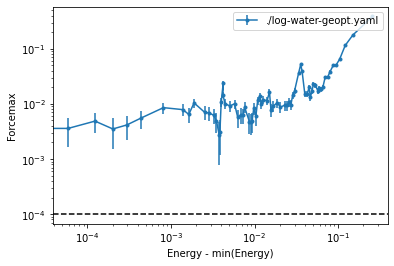

In [8]:
water_geopt.geopt_plot()

We can extract the steps of the geometry optimization process, and then visualize.

In [9]:
from copy import deepcopy
optsys = []

for inst in water_geopt:
    optsys.append(deepcopy(sys))
    optsys[-1].update_positions_from_dict(inst.log["Atomic structure"])

In [10]:
from BigDFT.Visualization import InlineVisualizer
viz = InlineVisualizer(400,300)
viz.display_system(*optsys)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Molecular dynamics

Then we run a molecular dynamics trajectory with fixed NVE (Number of particles, Volume, Energy) conditions.
To fix the MD time step, such a value has to be small enough to guarantee a proper integration of
the MD trajectory in terms of Energy conservation and a low ratio (below $\sim 2 \%$) between the kinetic energy and the total energy. It is import to check that Energy is conserved during an NVE MD run. On the other side, the time step should not be too small to reduce the total number of MD steps needed
to reach the desired overall time for the evolution of the target properties to be observed.

Only the $\Gamma$ point has been used
for the *k*-space integration during the MD trajectory.
The choice of *k*-points both for the geoemetry optimization and MD depends on the cell sizes.
In the present case, although the cell is small,
we simply want to save computational time and we placed at $\Gamma$ point.
The molecular dynamics simulations use the Born-Oppenheimer method.
The time step for the MD simulation has been set to 0.5 fs.
To accelerate the tutorial, we run only ten steps.

In [11]:
del water_inp['geopt']

In [12]:
water_inp['md'] = {'mdsteps': 10, 'timestep': 20.6706866726, 'temperature': 330.0, 'print_frequency': 10}
#{'thermostat': 'nose_hoover_chain','restart_pos': 'Yes','restart_vel': 'Yes','restart_nose': 'Yes'}
# include ** 'thermostat': 'nose_hoover_chain' ** to run an MD trajectory at the fixed temperature.
# include the three restart keys for subsequent the restart an MD run.
study = calc.SystemCalculator() #Create a calculator

Initialize a Calculator with OMP_NUM_THREADS=2 and command mpirun -np 2 /Users/wddawson/Documents/CEA/binaries/bds/install/bin/bigdft


In [13]:
water_md = study.run(posinp=optsys[-1].get_posinp(),
                                   name="water-md",input=water_inp) #Run the code with the name scheme md

Creating the yaml input file "./water-md.yaml"
Executing command:  mpirun -np 2 /Users/wddawson/Documents/CEA/binaries/bds/install/bin/bigdft -n water-md
Found 11 different runs


In [16]:
print(water_md[0].log['(MD)'])

{'istep': 0, 'T': 330.0, 'Eke': 0.018811, 'Epe': -68.900582, 'Ete': -68.881771, 'tcpu': 0.0}


In [17]:
md_trajectory = []
md_steps = []
temperatures = []
kinetic_energies = []
tot_energies = []
ene_ratio = []
for log in water_md:
    md_trajectory.append(log.log['Atomic structure'])
    md_info = log.log['(MD)']
    md_steps.append(md_info['istep'])
    temperatures.append(md_info['T'])
    ekin = md_info['Eke']
    etot = md_info['Ete']
    ratio = ekin / etot * 100.00
    kinetic_energies.append(ekin)
    tot_energies.append(etot)
    ene_ratio.append(ratio)

Here we check than the MD total energy is constant during the whole run.

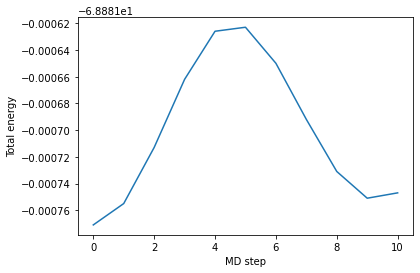

In [18]:
plt.plot(md_steps,tot_energies)
plt.xlabel('MD step')
plt.ylabel('Total energy')
plt.show()

Following we plot the ratio between the kinetic energy and the total energy. The lower the MD time step is, the lower is such ratio. It is enough to have a ratio below $\sim 2 \%$. In our case we are even below 0.03 $\%$.

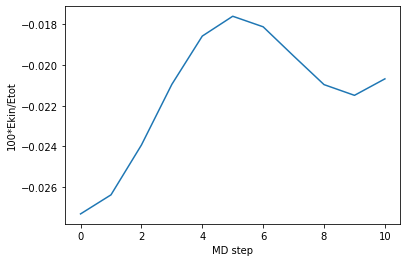

In [19]:
plt.plot(md_steps,ene_ratio)
plt.xlabel('MD step')
plt.ylabel('100*Ekin/Etot')
plt.show()

Following we check the temperature during our NVE MD run.

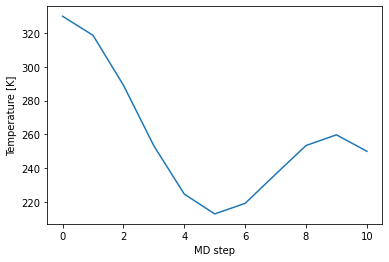

In [20]:
plt.plot(md_steps,temperatures)
plt.xlabel('MD step')
plt.ylabel('Temperature [K]')
plt.show()

Finally, we can visualize the trajectory of the water molecules.

In [21]:
trajectory = []

for inst in water_md:
    trajectory.append(deepcopy(sys))
    trajectory[-1].update_positions_from_dict(inst.log["Atomic structure"])

In [22]:
viz = InlineVisualizer(400,300)
viz.display_system(*trajectory)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

We can also run an MD trjectory with fixed NVT conditions imposed by a Nose-Hoover thermostat with
a target temperature of 330 K. The temperature of 330 K is usually chosen
to avoid the glassy behavior of PBE liquid water on the 20 ps time scale
observed for trajectories at lower temperatures.
In MD runs, 1-2 ps of equilibration period is followed by 5 ps of production period.

An NVT run can be set with the key 'thermostat': 'nose_hoover_chain' in the 'md' dictionary.

## A 38 atoms Lennard-Jones cluster

Following we run an NVT molecular dynamics trajectory for a 38 atoms Lennard-Jones cluster in free boundary conditions, that is none of the three Cartesian directions is periodic in the simulation box.

As done for the water environment, first we relax the system and then we run a molecular dynamics trajectory.

### Geometry optimization

In [23]:
input_file = StringIO("""HETATM    1 MG   UNL     1      -0.002  -0.042  -0.058  1.00  0.00          Mg  
HETATM    2 MG   UNL     1      -0.002  -0.003   0.532  1.00  0.00          Mg  
HETATM    3 MG   UNL     1       0.131  -0.483   0.251  1.00  0.00          Mg  
HETATM    4 MG   UNL     1      -0.410  -0.285   0.251  1.00  0.00          Mg  
HETATM    5 MG   UNL     1      -0.389   0.286   0.216  1.00  0.00          Mg  
HETATM    6 MG   UNL     1       0.162   0.444   0.206  1.00  0.00          Mg  
HETATM    7 MG   UNL     1       0.484  -0.028   0.235  1.00  0.00          Mg  
HETATM    8 MG   UNL     1      -0.434  -0.571  -0.233  1.00  0.00          Mg  
HETATM    9 MG   UNL     1      -0.519   0.006  -0.288  1.00  0.00          Mg  
HETATM   10 MG   UNL     1      -0.150   0.462  -0.297  1.00  0.00          Mg  
HETATM   11 MG   UNL     1       0.404   0.271  -0.305  1.00  0.00          Mg  
HETATM   12 MG   UNL     1       0.641  -0.263  -0.252  1.00  0.00          Mg  
HETATM   13 MG   UNL     1      -0.017  -0.024  -0.625  1.00  0.00          Mg  
HETATM   14 MG   UNL     1       0.004   0.015   1.116  1.00  0.00          Mg  
HETATM   15 MG   UNL     1       0.142  -0.483   0.828  1.00  0.00          Mg  
HETATM   16 MG   UNL     1      -0.419  -0.279   0.829  1.00  0.00          Mg  
HETATM   17 MG   UNL     1      -0.398   0.314   0.802  1.00  0.00          Mg  
HETATM   18 MG   UNL     1       0.174   0.479   0.792  1.00  0.00          Mg  
HETATM   19 MG   UNL     1       0.508  -0.013   0.812  1.00  0.00          Mg  
HETATM   20 MG   UNL     1       0.646  -0.509   0.514  1.00  0.00          Mg  
HETATM   21 MG   UNL     1       0.277  -0.975   0.511  1.00  0.00          Mg  
HETATM   22 MG   UNL     1      -0.282  -0.776   0.531  1.00  0.00          Mg  
HETATM   23 MG   UNL     1      -0.836  -0.569   0.519  1.00  0.00          Mg  
HETATM   24 MG   UNL     1      -0.822   0.025   0.510  1.00  0.00          Mg  
HETATM   25 MG   UNL     1      -0.794   0.614   0.490  1.00  0.00          Mg  
HETATM   26 MG   UNL     1      -0.227   0.778   0.478  1.00  0.00          Mg  
HETATM   27 MG   UNL     1       0.340   0.940   0.469  1.00  0.00          Mg  
HETATM   28 MG   UNL     1       0.677   0.456   0.483  1.00  0.00          Mg  
HETATM   29 MG   UNL     1       1.005  -0.040   0.486  1.00  0.00          Mg  
HETATM   30 MG   UNL     1       0.538  -0.794   0.001  1.00  0.00          Mg  
HETATM   31 MG   UNL     1       0.133  -0.526  -0.339  1.00  0.00          Mg  
HETATM   32 MG   UNL     1      -0.056  -0.965   0.011  1.00  0.00          Mg  
HETATM   33 MG   UNL     1      -0.929  -0.283   0.008  1.00  0.00          Mg  
HETATM   34 MG   UNL     1      -0.924   0.313   0.000  1.00  0.00          Mg  
HETATM   35 MG   UNL     1      -0.550   0.786  -0.021  1.00  0.00          Mg  
HETATM   36 MG   UNL     1       0.025   0.951  -0.031  1.00  0.00          Mg  
HETATM   37 MG   UNL     1       0.593   0.749  -0.027  1.00  0.00          Mg  
HETATM   38 MG   UNL     1       0.915   0.247  -0.026  1.00  0.00          Mg  """)

In [24]:
ljsys = read_pdb(input_file)

In [27]:
LJ_inp = I.Inputfile()
LJ_inp['mode'] = {'method': 'lj'}
LJ_inp.optimize_geometry(method="SQNM", nsteps=500, frac_fluct=0.0, forcemax = 1e-3, betax=1e-3)
LJ_inp["geopt"]["nhistx"] = 15
LJ_inp["geopt"]["steepthresh"] = 100
LJ_inp["geopt"]["trustr"] = 0.1

In [28]:
LJ_geopt = study.run(posinp=ljsys.get_posinp(), name="LJ-geopt", 
                                  input=LJ_inp) #Run the code with the name scheme geopt

Creating the yaml input file "./LJ-geopt.yaml"
Executing command:  mpirun -np 2 /Users/wddawson/Documents/CEA/binaries/bds/install/bin/bigdft -n LJ-geopt


In [29]:
tot_energies = []
forces = []
for step in LJ_geopt.log['Initializing LENNARD_JONES_RUN_MODE']:
    tot_energies.append(step['LENNARD_JONES_RUN_MODE']['Energy (Hartree)'])
    forces.append(step['LENNARD_JONES_RUN_MODE']['Force Norm (Hartree/Bohr)'])
ene_min = min(tot_energies)
tot_energies = [ene - ene_min for ene in tot_energies]

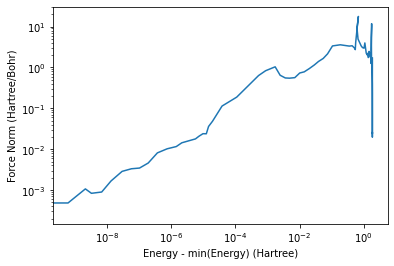

In [30]:
plt.plot(tot_energies,forces)
plt.loglog()
plt.xlabel('Energy - min(Energy) (Hartree)')
plt.ylabel('Force Norm (Hartree/Bohr)')
plt.show()

### Molecular dynamics

In [31]:
del LJ_inp['geopt']

The Lennard Jones code does not print the updated positions to the logfile, because it is typically used for very long trajectories. Instead, we can get the positions from a file which is created after the run.

In [32]:
import yaml

In [33]:
with open(r'final_LJ-geopt.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    posinp = yaml.load(file, Loader=yaml.FullLoader)
    
optljsys = deepcopy(ljsys)
optljsys.update_positions_from_dict(posinp)

Run MD.

In [34]:
LJ_inp['md'] = {'mdsteps': 10000, 'timestep': 1.0, 'temperature': 330.0, 'print_frequency': 100,
                        'thermostat': 'nose_hoover_chain'}
#{'restart_pos': 'Yes','restart_vel': 'Yes','restart_nose': 'Yes'}

In [35]:
LJ_md = study.run(posinp=optljsys.get_posinp(), name="LJ-md",
                               input=LJ_inp) #Run the code with the name scheme md

Creating the yaml input file "./LJ-md.yaml"
Executing command:  mpirun -np 2 /Users/wddawson/Documents/CEA/binaries/bds/install/bin/bigdft -n LJ-md


In [36]:
print(LJ_md.log['Initializing LENNARD_JONES_RUN_MODE'][0]['(MD)'])

{'istep': 0, 'T': 330.0, 'Eke': 0.059568, 'Epe': -172.877736, 'Ete': -172.816601, 'tcpu': 0.0}


In [37]:
md_steps = []
temperatures = []
kinetic_energies = []
tot_energies = []
ene_ratio = []
for log in LJ_md.log['Initializing LENNARD_JONES_RUN_MODE']:
    md_info = log['(MD)']
    md_steps.append(md_info['istep'])
    temperatures.append(md_info['T'])
    ekin = md_info['Eke']
    etot = md_info['Ete']
    ratio = ekin / etot * 100.00
    kinetic_energies.append(ekin)
    tot_energies.append(etot)
    ene_ratio.append(ratio)

In this NVT run, the total energy is not constant during the whole run.

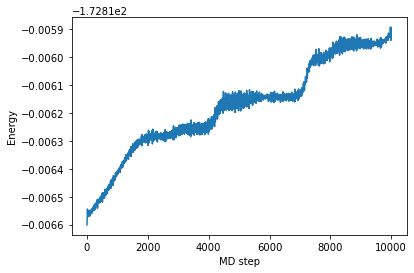

In [38]:
plt.plot(md_steps,tot_energies)
plt.xlabel('MD step')
plt.ylabel('Energy')
plt.show()

Following we plot the ratio between the kinetic energy and the total energy. The lower the MD time step is, the lower is such ratio. It is enough to have a ratio below $\sim 2 \%$. In our case we are even below 0.03 $\%$.

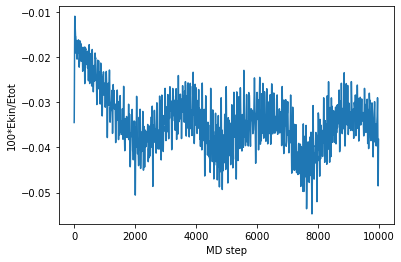

In [39]:
plt.plot(md_steps,ene_ratio)
plt.xlabel('MD step')
plt.ylabel('100*Ekin/Etot')
plt.show()

Following we check the temperature during our NVT MD run, which is well aroung 330 K.

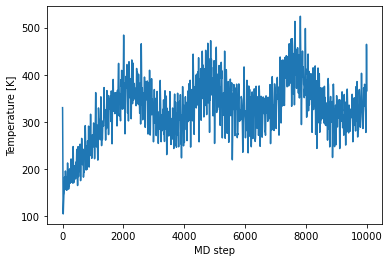

In [40]:
plt.plot(md_steps,temperatures)
plt.xlabel('MD step')
plt.ylabel('Temperature [K]')
plt.show()